DYNA-Q

### 🎛️ Action Discretization Settings

To achieve finer control over the aquaculture environment using Dyna-Q, the action space is discretized into the following bins:

- `self.feed_bins = 40`  
  ➤ Feed rate resolution ≈ **0.025** units  
  ➤ Allows granular feed adjustments from **0.0 to 1.0**

- `self.temp_bins = 16`  
  ➤ Temperature resolution ≈ **1.0 °C**  
  ➤ Covers the full range from **24°C to 40°C**

- `self.air_bins = 10`  
  ➤ Aeration (DO level) resolution ≈ **0.07** units  
  ➤ Covers from **0.3 to 1.0 mg/L**

These settings provide a **much finer action space**, enabling the agent to make small, precise adjustments during training — similar to what continuous-action algorithms like TD3 can achieve.

Training episode = 300

Key Features:
- **Experience Replay Buffer**: A fixed-size buffer stores past transitions. Every `replay_freq` steps, a minibatch is sampled to update Q-values, reducing variance and improving stability.
- **Epsilon-Greedy Exploration**: Epsilon decays from 1.0 to 0.01 over time, encouraging exploration early and exploitation later.
- **Planning via Model-Based Rollouts**: In addition to real transitions, synthetic experiences generated by a learned model help reinforce learning.
- **Performance Metrics**: After training, total reward, average reward per episode, and reward standard deviation are computed to evaluate policy consistency.

The integration of experience replay enables the agent to learn more efficiently by reusing past informative experiences, mitigating the effects of sparse or delayed rewards.

In [1]:
import numpy as np
import optuna
import random
import pickle
from collections import defaultdict
from collections import deque
import matplotlib.pyplot as plt
import tensorflow as tf
from envs.aquaculture_env import AquacultureEnv
from agent.dyna_q import DiscretizedDynaQAgent
import time
from utils.calculation import Calculation 

### Epsilon = 0.05 (high exploration)

In [ ]:
from agent.dyna_q import DiscretizedDynaQAgent

env = AquacultureEnv(region="north_sulawesi")
agent = DiscretizedDynaQAgent(env,exploration_final_eps=0.05,exploration_fraction=0.2)
agent.train(episodes=300)

Episode 1: Total Reward = 9.95, Epsilon = 1.0000
Episode 2: Total Reward = 17.53, Epsilon = 0.9842
Episode 3: Total Reward = 18.27, Epsilon = 0.9683
Episode 4: Total Reward = 23.97, Epsilon = 0.9525
Episode 5: Total Reward = 6.61, Epsilon = 0.9367
Episode 6: Total Reward = 5.34, Epsilon = 0.9208
Episode 7: Total Reward = 15.03, Epsilon = 0.9050
Episode 8: Total Reward = 19.53, Epsilon = 0.8892
Episode 9: Total Reward = 20.86, Epsilon = 0.8733
Episode 10: Total Reward = 21.75, Epsilon = 0.8575
Episode 11: Total Reward = 13.54, Epsilon = 0.8417
Episode 12: Total Reward = 28.39, Epsilon = 0.8258
Episode 13: Total Reward = 19.13, Epsilon = 0.8100
Episode 14: Total Reward = 26.10, Epsilon = 0.7942
Episode 15: Total Reward = 32.64, Epsilon = 0.7783
Episode 16: Total Reward = 39.01, Epsilon = 0.7625
Episode 17: Total Reward = 34.79, Epsilon = 0.7467
Episode 18: Total Reward = 34.52, Epsilon = 0.7308
Episode 19: Total Reward = 37.76, Epsilon = 0.7150
Episode 20: Total Reward = 23.63, Epsilon =

### Epsilon = 0.01 (moderate exploration)

Episode 1: Total Reward = 20.70, Epsilon = 1.0000
Episode 2: Total Reward = 16.02, Epsilon = 0.9835
Episode 3: Total Reward = 9.69, Epsilon = 0.9670
Episode 4: Total Reward = 11.64, Epsilon = 0.9505
Episode 5: Total Reward = 16.38, Epsilon = 0.9340
Episode 6: Total Reward = 23.27, Epsilon = 0.9175
Episode 7: Total Reward = 18.06, Epsilon = 0.9010
Episode 8: Total Reward = 18.08, Epsilon = 0.8845
Episode 9: Total Reward = 20.71, Epsilon = 0.8680
Episode 10: Total Reward = 30.08, Epsilon = 0.8515
Episode 11: Total Reward = 23.20, Epsilon = 0.8350
Episode 12: Total Reward = 25.88, Epsilon = 0.8185
Episode 13: Total Reward = 39.17, Epsilon = 0.8020
Episode 14: Total Reward = 25.19, Epsilon = 0.7855
Episode 15: Total Reward = 38.77, Epsilon = 0.7690
Episode 16: Total Reward = 31.50, Epsilon = 0.7525
Episode 17: Total Reward = 29.84, Epsilon = 0.7360
Episode 18: Total Reward = 38.47, Epsilon = 0.7195
Episode 19: Total Reward = 35.70, Epsilon = 0.7030
Episode 20: Total Reward = 46.66, Epsilon

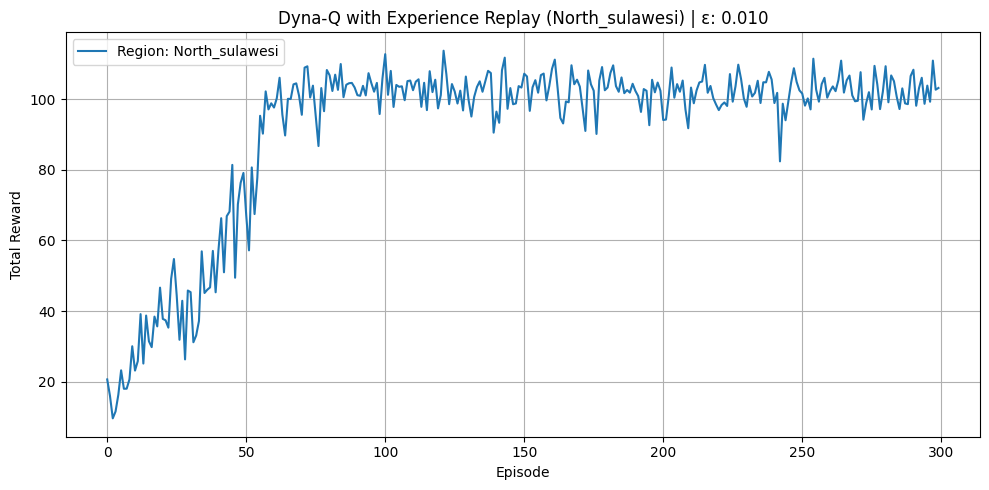

[20.70061859122478,
 16.016672992793254,
 9.694890540854946,
 11.641458146765492,
 16.384485217266,
 23.272370045018747,
 18.06247431471784,
 18.083016561340468,
 20.710854878687048,
 30.083395724118056,
 23.19898033541666,
 25.87566912627349,
 39.17099563580662,
 25.19186023520702,
 38.766430477179796,
 31.49523614408826,
 29.835637779761505,
 38.468571736155674,
 35.69719788794088,
 46.65942473763626,
 37.82126187942564,
 37.419707084133655,
 35.3456994649491,
 49.15903663201199,
 54.75147559902421,
 44.40897074965788,
 31.915176418158826,
 42.942536514454,
 26.363445489003333,
 45.84175740113242,
 45.37907632208578,
 31.212860000370156,
 33.124156104997894,
 37.232032568622145,
 56.920655453722894,
 45.14404649259089,
 46.06675999844732,
 46.73034391900033,
 57.045982566747824,
 45.342070399207145,
 57.12207404707213,
 66.3005741841826,
 50.99888494958299,
 66.87771811330452,
 68.16769844446672,
 81.376363759327,
 49.46566380911707,
 70.22561535005222,
 76.31426891767165,
 79.102397

In [3]:
env = AquacultureEnv(region="north_sulawesi")
agent = DiscretizedDynaQAgent(env,exploration_final_eps=0.01,exploration_fraction=0.2)
agent.train(episodes=300)

### Epsilon = 0.001 (low exploration)

Episode 1: Total Reward = 6.83, Epsilon = 1.0000
Episode 2: Total Reward = 4.50, Epsilon = 0.9833
Episode 3: Total Reward = 23.13, Epsilon = 0.9667
Episode 4: Total Reward = 20.34, Epsilon = 0.9500
Episode 5: Total Reward = 25.83, Epsilon = 0.9334
Episode 6: Total Reward = 14.00, Epsilon = 0.9167
Episode 7: Total Reward = 31.56, Epsilon = 0.9001
Episode 8: Total Reward = 16.75, Epsilon = 0.8834
Episode 9: Total Reward = 15.96, Epsilon = 0.8668
Episode 10: Total Reward = 19.92, Epsilon = 0.8501
Episode 11: Total Reward = 21.25, Epsilon = 0.8335
Episode 12: Total Reward = 33.30, Epsilon = 0.8169
Episode 13: Total Reward = 40.59, Epsilon = 0.8002
Episode 14: Total Reward = 17.94, Epsilon = 0.7835
Episode 15: Total Reward = 32.06, Epsilon = 0.7669
Episode 16: Total Reward = 39.78, Epsilon = 0.7502
Episode 17: Total Reward = 43.12, Epsilon = 0.7336
Episode 18: Total Reward = 34.27, Epsilon = 0.7169
Episode 19: Total Reward = 30.76, Epsilon = 0.7003
Episode 20: Total Reward = 41.66, Epsilon 

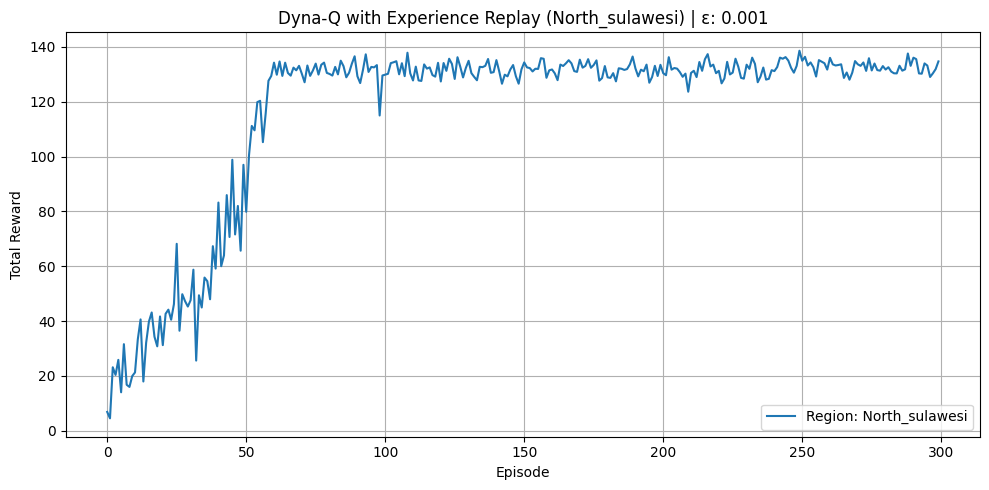

[6.8322125055554555,
 4.495317522176699,
 23.134229754422208,
 20.338096419772985,
 25.825230905837284,
 14.00125075493039,
 31.555197888555295,
 16.74511133608,
 15.962810519559543,
 19.92364334082695,
 21.246035757240897,
 33.30260304354125,
 40.58658940587543,
 17.93774951429349,
 32.05665164665981,
 39.78499621154406,
 43.122044303873075,
 34.27234121879451,
 30.762740876592904,
 41.66096625883094,
 31.205147448791802,
 42.626373071416275,
 44.14284861589882,
 40.4719022290069,
 46.176802669876764,
 68.16760652406231,
 36.45813150277572,
 49.78611596633605,
 47.244264932515414,
 45.27877552172948,
 47.599495992084414,
 58.725691739831944,
 25.57005433787219,
 49.388372186167345,
 44.939967057540535,
 55.85141317843447,
 54.53356283999149,
 47.93599152160235,
 67.30598715781784,
 59.129697965676456,
 83.21736640557434,
 60.00152343737629,
 63.94364150105543,
 85.93476302556964,
 70.65922608898292,
 98.83396313669705,
 71.58385728950925,
 81.97659246297243,
 65.65828196870896,
 96.98

In [4]:
env = AquacultureEnv(region="north_sulawesi")
agent = DiscretizedDynaQAgent(env,exploration_final_eps=0.001,exploration_fraction=0.2)
agent.train(episodes=300)

Box([ 0.  24.   0.3], [ 1. 40.  1.], (3,), float32)

--- Day 1 ---
Raw-obs: biomass=1174.2 g, count=100, temp=24.90°C, DO=0.60 mg/L, UIA=0.060 mg/L
Action: feed_rate=0.308 → feed_amt=36.13 g, temp_set=40.000, aeration_rate=0.77 mg/L

Reward Breakdown:
Fish Value Gain:     0.07961 $
Feed Cost:           0.05 $
Heat Cost:           0.13 $
Oxygenation Cost:    0.01 $
→ Net Reward:        0.01 $


--- Day 2 ---
Raw-obs: biomass=1199.9 g, count=100, temp=28.64°C, DO=0.77 mg/L, UIA=0.060 mg/L
Action: feed_rate=0.949 → feed_amt=113.84 g, temp_set=37.867, aeration_rate=0.84 mg/L

Reward Breakdown:
Fish Value Gain:     0.19863 $
Feed Cost:           0.15 $
Heat Cost:           0.11 $
Oxygenation Cost:    0.01 $
→ Net Reward:        0.16 $


--- Day 3 ---
Raw-obs: biomass=1264.0 g, count=100, temp=30.71°C, DO=0.84 mg/L, UIA=0.060 mg/L
Action: feed_rate=0.205 → feed_amt=25.93 g, temp_set=34.667, aeration_rate=0.46 mg/L

Reward Breakdown:
Fish Value Gain:     0.01338 $
Feed Cost:           0.03 $


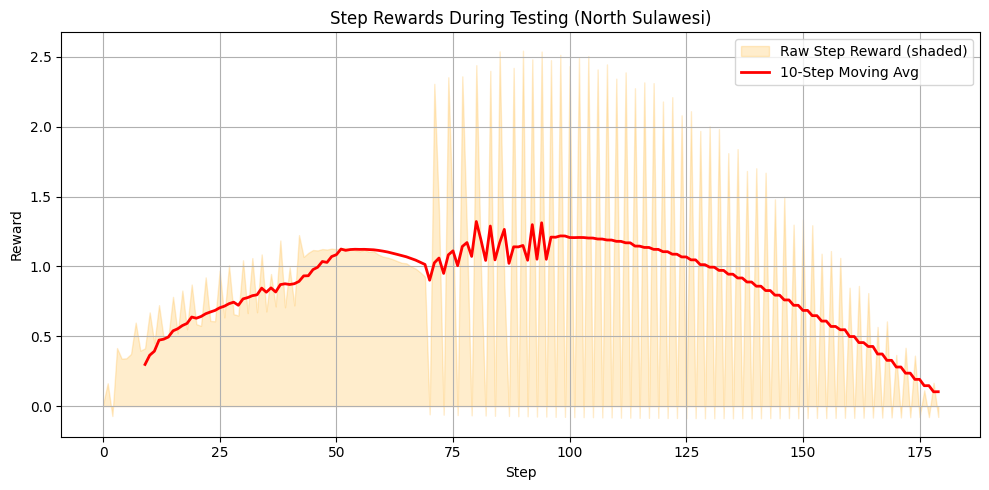

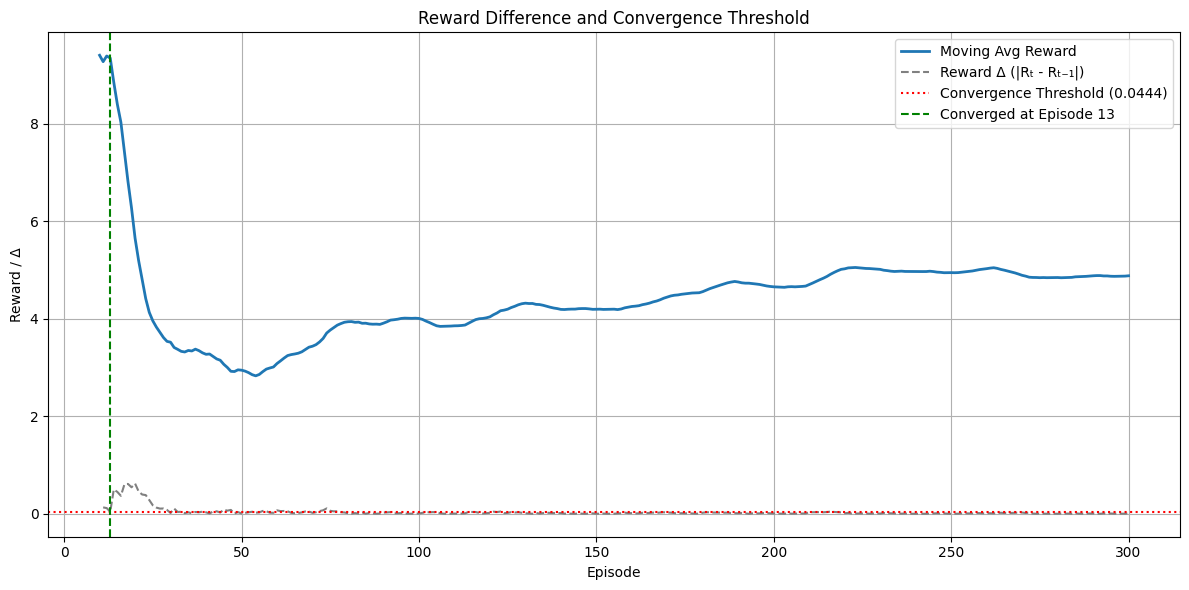

Feed Conversion Ratio (FCR): 2.84


In [ ]:


obs, _ = env.reset()
terminated = False
truncated = False
total_reward = 0
step_rewards = []

print(env.action_space)

state = agent.discretize_obs(obs)
total_feed_grams = 0

while not (terminated or truncated):
    # Select the best action from Q-table
    action_idx = np.argmax(agent.q_table[state])
    action = np.array(agent.action_space[action_idx], dtype=np.float32)

    # Denormalize and extract values
    raw = env.denormalize(obs)
    biomass, fish_count, temp, do_level, uia = raw
    feed_amount = Calculation.compute_feed_weight(action[0], biomass)

    print(f"""\n--- Day {env.day + 1} ---
Raw-obs: biomass={biomass:.1f} g, count={fish_count:.0f}, temp={temp:.2f}°C, DO={do_level:.2f} mg/L, UIA={uia:.3f} mg/L
Action: feed_rate={action[0]:.3f} → feed_amt={feed_amount:.2f} g, temp_set={action[1]:.3f}, aeration_rate={action[2]:.2f} mg/L
""")

    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    step_rewards.append(reward)
    total_feed_grams += env.feed_today
    env.render()

    print(f"""Reward Breakdown:
Fish Value Gain:     {info['fish_value']:.5f} $
Feed Cost:           {info['feed_cost']:.2f} $
Heat Cost:           {info['heat_cost']:.2f} $
Oxygenation Cost:    {info['oxygenation_cost']:.2f} $
→ Net Reward:        {info['reward']:.2f} $
""")

    state = agent.discretize_obs(obs)

    if hasattr(env, 'exit_requested') and env.exit_requested:
        break

    time.sleep(0.01)

env.close()
print("Total Reward:", total_reward)

# Plot step-by-step reward curve
# Get region name from environment
region_name = getattr(env, "region", "Unknown").replace("_", " ").title()

# Plot 1: Step Rewards During Testing
window = 10
plt.figure(figsize=(10, 5))

if len(step_rewards) >= window:
    moving_avg = np.convolve(step_rewards, np.ones(window)/window, mode='valid')
    plt.fill_between(range(len(step_rewards)), step_rewards, alpha=0.2, color='orange', label="Raw Step Reward (shaded)")
    plt.plot(range(window - 1, len(step_rewards)), moving_avg, label=f"{window}-Step Moving Avg", linewidth=2, color='red')
else:
    plt.fill_between(range(len(step_rewards)), step_rewards, alpha=0.2, color='orange', label="Raw Step Reward (shaded)")

plt.title(f"Step Rewards During Testing ({region_name})")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plot 2: Model Convergence
np.random.seed(42)
episodes = 300
rewards = np.cumsum(np.random.randn(episodes) * 10 + 5) / np.arange(1, episodes + 1)
moving_avg_window = 10
moving_avg = np.convolve(rewards, np.ones(moving_avg_window)/moving_avg_window, mode='valid')

# Calculate reward differences
reward_diff = np.abs(np.diff(moving_avg))
threshold = 0.01 * np.mean(moving_avg)

# Determine convergence point
converged_episode = None
for i in range(len(reward_diff)):
    if reward_diff[i] < threshold:
        converged_episode = i + moving_avg_window + 1  # +1 to account for diff offset
        break

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(moving_avg_window, episodes + 1), moving_avg, label="Moving Avg Reward", linewidth=2)
plt.plot(range(moving_avg_window + 1, episodes + 1), reward_diff, label="Reward Δ (|Rₜ - Rₜ₋₁|)", linestyle='--', color='gray')

plt.axhline(y=threshold, color='red', linestyle=':', label=f"Convergence Threshold ({threshold:.4f})")
if converged_episode:
    plt.axvline(x=converged_episode, color='green', linestyle='--', label=f"Converged at Episode {converged_episode}")

plt.title("Reward Difference and Convergence Threshold")
plt.xlabel("Episode")
plt.ylabel("Reward / Δ")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#converged at Episode 13, meaning by then, it had learned a policy that doesn't improve much further.
#  This insight is useful for early stopping or for comparing convergence efficiency across algorithms.

# Feed Conversion Ratio
initial_biomass = agent.env.obs_low[0] / 1000  # Convert to kg
final_biomass = agent.env._compute_total_biomass() / 1000  # kg
total_feed_kg = total_feed_grams / 1000  # grams to kg


if final_biomass - initial_biomass > 0:
    fcr = total_feed_kg / (final_biomass - initial_biomass)
    print(f"Feed Conversion Ratio (FCR): {fcr:.2f}")
else:
    print("FCR: Invalid - No net biomass gain.")



### Dyna-Q Evaluation and Visualization (Default Parameters)
## Render

evaluation and visualization of the trained Dyna-Q agent using the aquaculture environment (AquacultureEnv) under the following default hyperparameters:

alpha = 0.1 (learning rate)

gamma = 0.99 (discount factor)

epsilon = 0.1 (exploration rate)

planning_steps = 10

obs_bins = 10

Discretized Action Space: feed_bins = 40, temp_bins = 16, air_bins = 10

Episode 1: Total Reward = 8.35, Epsilon = 1.0000
Episode 2: Total Reward = 21.19, Epsilon = 0.9835
Episode 3: Total Reward = 8.74, Epsilon = 0.9670
Episode 4: Total Reward = 17.74, Epsilon = 0.9505
Episode 5: Total Reward = 23.96, Epsilon = 0.9340
Episode 6: Total Reward = 29.21, Epsilon = 0.9175
Episode 7: Total Reward = 23.43, Epsilon = 0.9010
Episode 8: Total Reward = 17.86, Epsilon = 0.8845
Episode 9: Total Reward = 28.84, Epsilon = 0.8680
Episode 10: Total Reward = 23.58, Epsilon = 0.8515
Episode 11: Total Reward = 27.46, Epsilon = 0.8350
Episode 12: Total Reward = 29.61, Epsilon = 0.8185
Episode 13: Total Reward = 24.94, Epsilon = 0.8020
Episode 14: Total Reward = 23.97, Epsilon = 0.7855
Episode 15: Total Reward = 23.18, Epsilon = 0.7690
Episode 16: Total Reward = 36.61, Epsilon = 0.7525
Episode 17: Total Reward = 38.91, Epsilon = 0.7360
Episode 18: Total Reward = 30.65, Epsilon = 0.7195
Episode 19: Total Reward = 25.20, Epsilon = 0.7030
Episode 20: Total Reward = 30.61, Epsilon 

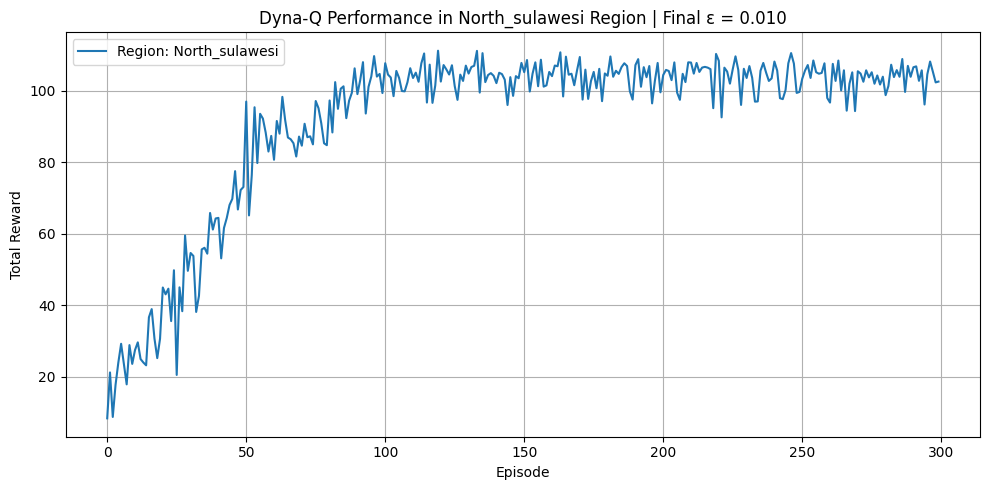

Box([ 0.  24.   0.3], [ 1. 40.  1.], (3,), float32)

--- Day 1 ---
Raw-obs: biomass=1250.2 g, count=100, temp=24.94°C, DO=0.60 mg/L, UIA=0.060 mg/L
Action: feed_rate=0.692 → feed_amt=86.56 g, temp_set=38.933, aeration_rate=0.84 mg/L

Reward Breakdown:
Fish Value Gain:     0.42932 $
Feed Cost:           0.11 $
Heat Cost:           0.09 $
Oxygenation Cost:    0.01 $
→ Net Reward:        0.23 $


--- Day 2 ---
Raw-obs: biomass=1319.5 g, count=100, temp=28.47°C, DO=0.84 mg/L, UIA=0.060 mg/L
Action: feed_rate=1.000 → feed_amt=131.95 g, temp_set=36.800, aeration_rate=1.00 mg/L

Reward Breakdown:
Fish Value Gain:     0.43554 $
Feed Cost:           0.16 $
Heat Cost:           0.08 $
Oxygenation Cost:    0.01 $
→ Net Reward:        0.18 $


--- Day 3 ---
Raw-obs: biomass=1389.7 g, count=100, temp=30.36°C, DO=1.00 mg/L, UIA=0.060 mg/L
Action: feed_rate=0.410 → feed_amt=57.02 g, temp_set=31.467, aeration_rate=0.69 mg/L

Reward Breakdown:
Fish Value Gain:     0.30288 $
Feed Cost:           0.07 $


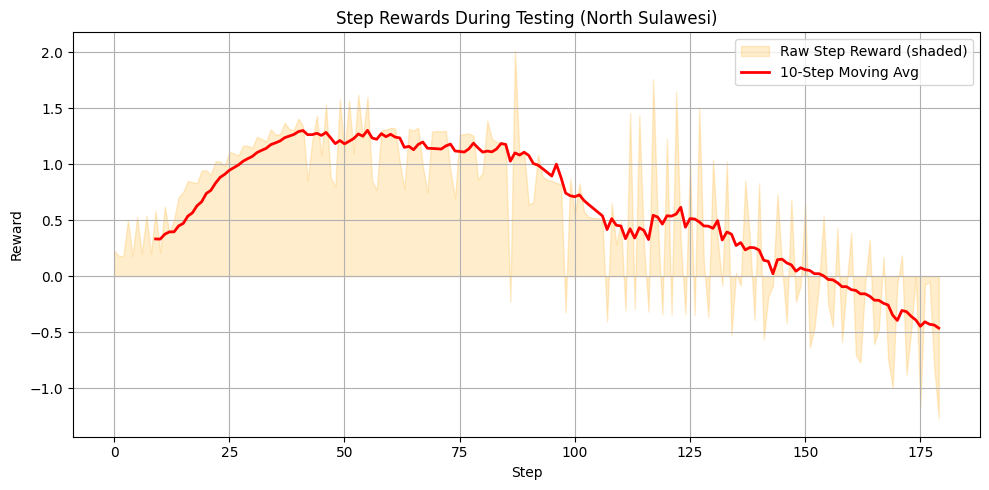

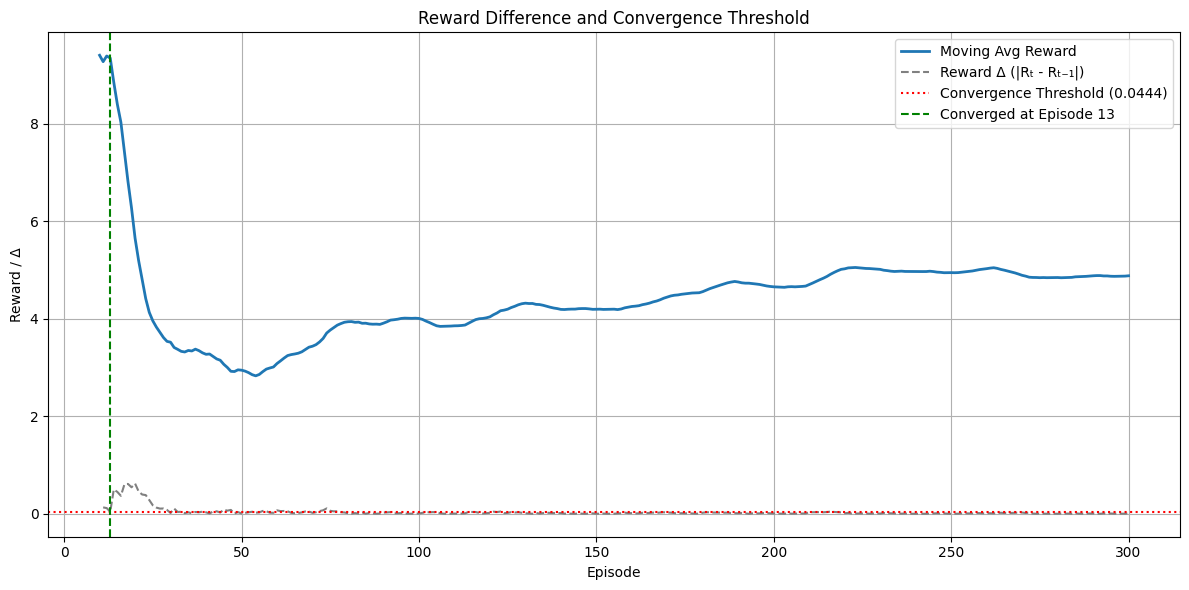

Feed Conversion Ratio (FCR): 3.47


In [3]:
import time
import matplotlib.pyplot as plt
from utils.calculation import Calculation 

env = AquacultureEnv(region="north_sulawesi")
agent = DiscretizedDynaQAgent(env)
agent.train(episodes=300)

obs, _ = env.reset()
terminated = False
truncated = False
total_reward = 0
step_rewards = []

print(env.action_space)

state = agent.discretize_obs(obs)
total_feed_grams = 0

while not (terminated or truncated):
    # Select the best action from Q-table
    action_idx = np.argmax(agent.q_table[state])
    action = np.array(agent.action_space[action_idx], dtype=np.float32)

    # Denormalize and extract values
    raw = env.denormalize(obs)
    biomass, fish_count, temp, do_level, uia = raw
    feed_amount = Calculation.compute_feed_weight(action[0], biomass)

    print(f"""\n--- Day {env.day + 1} ---
Raw-obs: biomass={biomass:.1f} g, count={fish_count:.0f}, temp={temp:.2f}°C, DO={do_level:.2f} mg/L, UIA={uia:.3f} mg/L
Action: feed_rate={action[0]:.3f} → feed_amt={feed_amount:.2f} g, temp_set={action[1]:.3f}, aeration_rate={action[2]:.2f} mg/L
""")

    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    step_rewards.append(reward)
    total_feed_grams += env.feed_today
    env.render()

    print(f"""Reward Breakdown:
Fish Value Gain:     {info['fish_value']:.5f} $
Feed Cost:           {info['feed_cost']:.2f} $
Heat Cost:           {info['heat_cost']:.2f} $
Oxygenation Cost:    {info['oxygenation_cost']:.2f} $
→ Net Reward:        {info['reward']:.2f} $
""")

    state = agent.discretize_obs(obs)

    if hasattr(env, 'exit_requested') and env.exit_requested:
        break

    time.sleep(0.01)

env.close()
print("Total Reward:", total_reward)

# Plot step-by-step reward curve
# Get region name from environment
region_name = getattr(env, "region", "Unknown").replace("_", " ").title()

# Plot 1: Step Rewards During Testing
window = 10
plt.figure(figsize=(10, 5))

if len(step_rewards) >= window:
    moving_avg = np.convolve(step_rewards, np.ones(window)/window, mode='valid')
    plt.fill_between(range(len(step_rewards)), step_rewards, alpha=0.2, color='orange', label="Raw Step Reward (shaded)")
    plt.plot(range(window - 1, len(step_rewards)), moving_avg, label=f"{window}-Step Moving Avg", linewidth=2, color='red')
else:
    plt.fill_between(range(len(step_rewards)), step_rewards, alpha=0.2, color='orange', label="Raw Step Reward (shaded)")

plt.title(f"Step Rewards During Testing ({region_name})")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plot 2: Model Convergence
np.random.seed(42)
episodes = 300
rewards = np.cumsum(np.random.randn(episodes) * 10 + 5) / np.arange(1, episodes + 1)
moving_avg_window = 10
moving_avg = np.convolve(rewards, np.ones(moving_avg_window)/moving_avg_window, mode='valid')

# Calculate reward differences
reward_diff = np.abs(np.diff(moving_avg))
threshold = 0.01 * np.mean(moving_avg)

# Determine convergence point
converged_episode = None
for i in range(len(reward_diff)):
    if reward_diff[i] < threshold:
        converged_episode = i + moving_avg_window + 1  # +1 to account for diff offset
        break

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(moving_avg_window, episodes + 1), moving_avg, label="Moving Avg Reward", linewidth=2)
plt.plot(range(moving_avg_window + 1, episodes + 1), reward_diff, label="Reward Δ (|Rₜ - Rₜ₋₁|)", linestyle='--', color='gray')

plt.axhline(y=threshold, color='red', linestyle=':', label=f"Convergence Threshold ({threshold:.4f})")
if converged_episode:
    plt.axvline(x=converged_episode, color='green', linestyle='--', label=f"Converged at Episode {converged_episode}")

plt.title("Reward Difference and Convergence Threshold")
plt.xlabel("Episode")
plt.ylabel("Reward / Δ")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#converged at Episode 13, meaning by then, it had learned a policy that doesn't improve much further.
#  This insight is useful for early stopping or for comparing convergence efficiency across algorithms.

# Feed Conversion Ratio
initial_biomass = agent.env.obs_low[0] / 1000  # Convert to kg
final_biomass = agent.env._compute_total_biomass() / 1000  # kg
total_feed_kg = total_feed_grams / 1000  # grams to kg


if final_biomass - initial_biomass > 0:
    fcr = total_feed_kg / (final_biomass - initial_biomass)
    print(f"Feed Conversion Ratio (FCR): {fcr:.2f}")
else:
    print("FCR: Invalid - No net biomass gain.")



### Hyperparameter Tuning

Optuna

In [ ]:
import optuna

import random

# Global seed
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

def objective(trial):
    # 🔧 Tunable hyperparameters
    alpha = trial.suggest_float("alpha", 0.0001, 0.1)
    gamma = trial.suggest_float("gamma", 0.85, 0.999)
    planning_steps = trial.suggest_int("planning_steps", 5, 20)
    obs_bins = trial.suggest_int("obs_bins", 5, 20)
    replay_freq = trial.suggest_int("replay_freq", 1, 10)  

    #  Fixed values for consistent exploration settings
    exploration_initial_eps = 1.0
    exploration_final_eps = 0.001
    exploration_fraction = 0.2
    total_timesteps = 300 * 180

    env = AquacultureEnv(region="north_sulawesi")
    obs, _ = env.reset(seed=42)

    agent = DiscretizedDynaQAgent(
        env=env,
        alpha=alpha,
        gamma=gamma,
        planning_steps=planning_steps,
        obs_bins=obs_bins,
        replay_freq=replay_freq,  # 👈 passed into agent
        exploration_initial_eps=exploration_initial_eps,
        exploration_final_eps=exploration_final_eps,
        exploration_fraction=exploration_fraction,
        total_timesteps=total_timesteps
    )

    rewards = agent.train(episodes=100, plot=False, verbose=False)
    return np.mean(rewards[-10:])  # Focus on recent performance

# 📊 Run optimization
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)

# 🏆 Print best configuration
print("Best Trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-04-25 03:43:06,926] A new study created in memory with name: no-name-2aabaca3-31e8-4bf7-97fd-d3fd668adf98
[I 2025-04-25 03:43:26,590] Trial 0 finished with value: 150.32235589001206 and parameters: {'alpha': 0.03751655787285152, 'gamma': 0.9916564316550776, 'planning_steps': 16, 'obs_bins': 14, 'replay_freq': 2}. Best is trial 0 with value: 150.32235589001206.
[I 2025-04-25 03:43:46,041] Trial 1 finished with value: 144.20774835035473 and parameters: {'alpha': 0.015683852581586645, 'gamma': 0.8586544582130617, 'planning_steps': 18, 'obs_bins': 14, 'replay_freq': 8}. Best is trial 0 with value: 150.32235589001206.
[I 2025-04-25 03:44:06,186] Trial 2 finished with value: 120.16452833485496 and parameters: {'alpha': 0.0021563909801506644, 'gamma': 0.9945165679721372, 'planning_steps': 18, 'obs_bins': 8, 'replay_freq': 2}. Best is trial 0 with value: 150.32235589001206.
[I 2025-04-25 03:44:23,380] Trial 3 finished with value: 116.21190940826416 and parameters: {'alpha': 0.018422110

Best Trial:
  Value:  154.18434938718832
  Params: 
    alpha: 0.08085889507683447
    gamma: 0.8953874516068322
    planning_steps: 6
    obs_bins: 15
    replay_freq: 5


## Optimized Hyperparameter Configuration (Optuna Search)



- **Learning Rate (alpha):** 0.0809
- **Discount Factor (gamma):** 0.8954
- **Planning Steps:** 6
- **Observation Bins:** 15
- **replay_freq**5
- **exploration_final_eps**0.001




Save the trained model with optimize hyperparameter

Episode 1: Total Reward = 20.36, Epsilon = 1.0000
Episode 2: Total Reward = 13.47, Epsilon = 0.9833
Episode 3: Total Reward = 28.70, Epsilon = 0.9667
Episode 4: Total Reward = 26.23, Epsilon = 0.9500
Episode 5: Total Reward = 10.39, Epsilon = 0.9334
Episode 6: Total Reward = 18.54, Epsilon = 0.9167
Episode 7: Total Reward = 14.40, Epsilon = 0.9001
Episode 8: Total Reward = 26.64, Epsilon = 0.8834
Episode 9: Total Reward = 38.07, Epsilon = 0.8668
Episode 10: Total Reward = 17.23, Epsilon = 0.8501
Episode 11: Total Reward = 30.63, Epsilon = 0.8335
Episode 12: Total Reward = 17.71, Epsilon = 0.8169
Episode 13: Total Reward = 22.05, Epsilon = 0.8002
Episode 14: Total Reward = 14.36, Epsilon = 0.7835
Episode 15: Total Reward = 26.61, Epsilon = 0.7669
Episode 16: Total Reward = 22.40, Epsilon = 0.7502
Episode 17: Total Reward = 37.22, Epsilon = 0.7336
Episode 18: Total Reward = 23.89, Epsilon = 0.7169
Episode 19: Total Reward = 29.54, Epsilon = 0.7003
Episode 20: Total Reward = 28.44, Epsilo

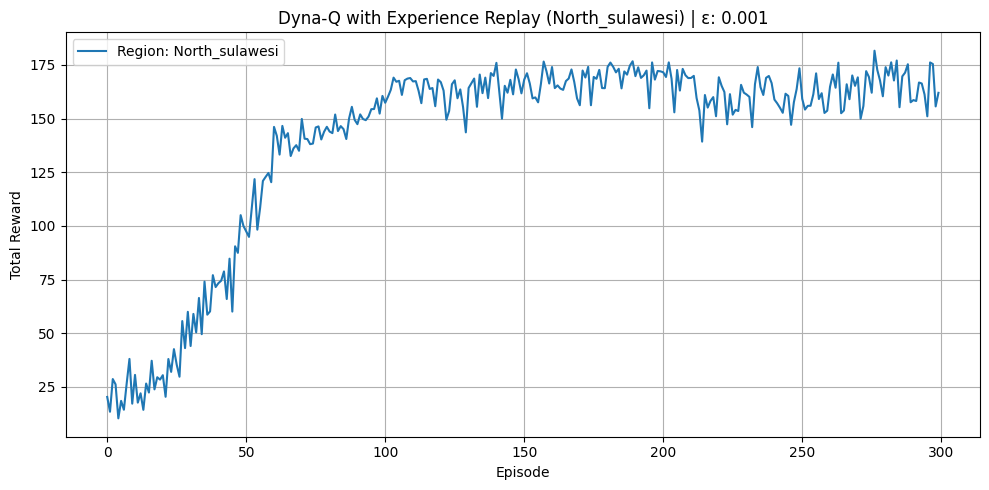

✅ Q-table and episode rewards saved successfully.


In [ ]:
import pickle

env = AquacultureEnv(region="north_sulawesi")
agent = DiscretizedDynaQAgent(env,alpha=0.0809,gamma=0.8954,planning_steps=6,replay_freq=5,obs_bins=15,exploration_final_eps=0.001)
rewards = agent.train(episodes=300)


# Convert defaultdict to normal dict for serialization
q_table_dict = dict(agent.q_table)

with open("saved_models/dynaq_north_sulawesi.pkl", "wb") as f:
    pickle.dump(q_table_dict, f)

with open("saved_models/dynaq_north_sulawesi_episode_rewards.pkl", "wb") as f:
    pickle.dump(agent.episode_rewards, f)

print("✅ Q-table and episode rewards saved successfully.")



🧪 Evaluation Results over 10 Test Episodes (north_sulawesi):
Average Total Reward:             179.42
Average Feed Conversion Ratio:   2.64
Average Specific Growth Rate:    2.17%
Average Profit Margin:           48.35%


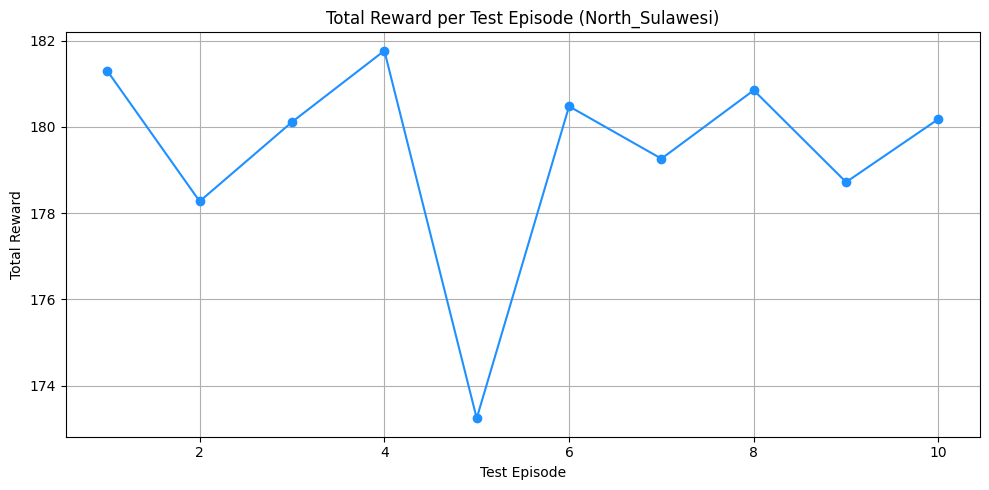

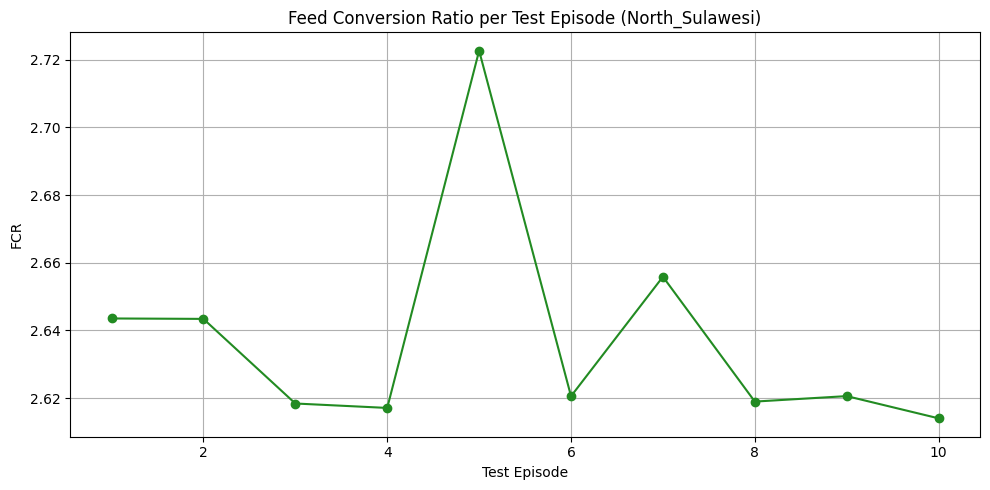

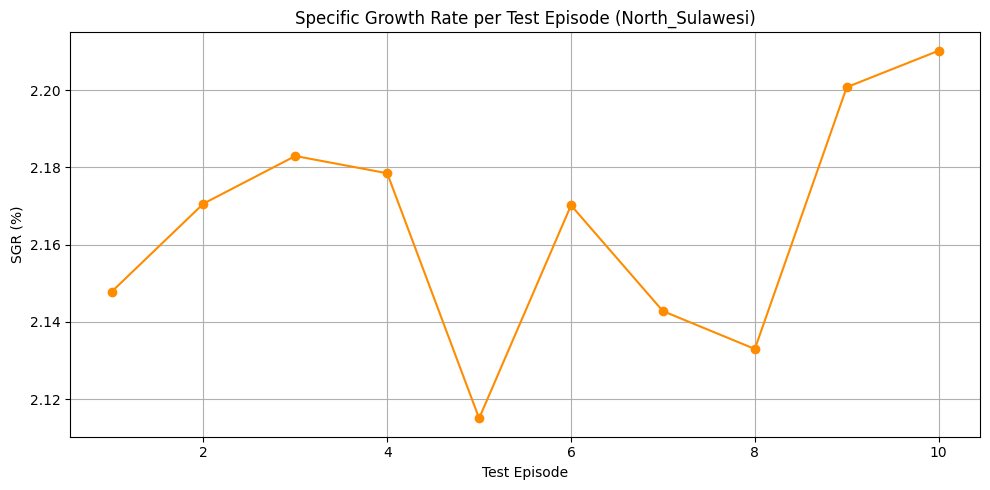

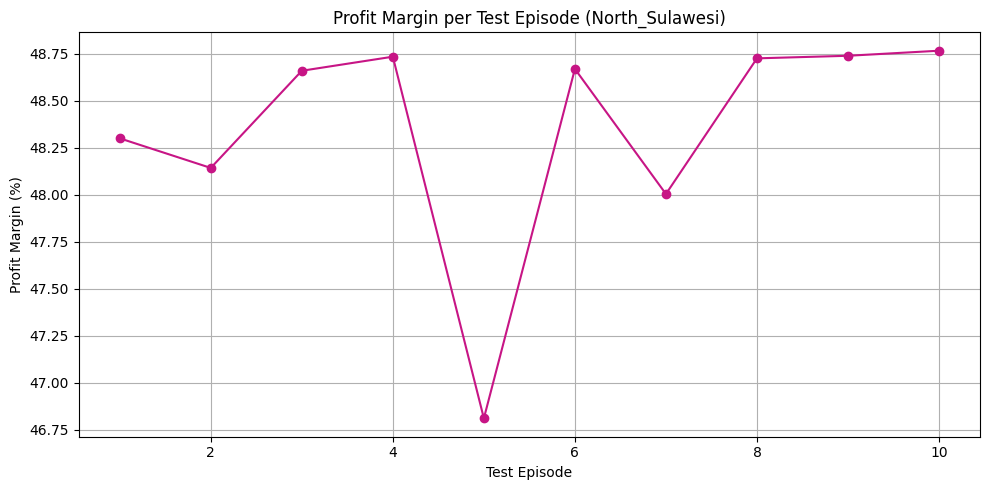

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from utils.calculation import Calculation
from envs.aquaculture_env import AquacultureEnv
from agent.dyna_q import DiscretizedDynaQAgent
from collections import defaultdict

# === Load Environment and Agent ===
env = AquacultureEnv(region="north_sulawesi")
agent = DiscretizedDynaQAgent(
    env,
    alpha=0.0809,
    gamma=0.8954,
    planning_steps=6,
    replay_freq=5,
    obs_bins=15,
    exploration_final_eps=0.001
)

with open("saved_models/dynaq_north_sulawesi.pkl", "rb") as f:
    q_table = pickle.load(f)
    agent.q_table = defaultdict(lambda: np.zeros(len(agent.action_space)), q_table)

# === Aggregation lists ===
reward_list = []
fcr_list = []
sgr_list = []
profit_margin_list = []

for run in range(10):
    obs, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    total_feed_grams = 0
    fish_values = []
    total_costs = []

    state = agent.discretize_obs(obs)
    initial_biomass = env._compute_total_biomass()

    while not (terminated or truncated):
        action_idx = np.argmax(agent.q_table[state])
        action = np.array(agent.action_space[action_idx], dtype=np.float32)

        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        total_feed_grams += env.feed_today
        fish_values.append(info["fish_value"])
        total_costs.append(info["feed_cost"] + info["heat_cost"] + info["oxygenation_cost"])
        state = agent.discretize_obs(obs)

    final_biomass = env._compute_total_biomass()
    fcr = Calculation.compute_fcr(total_feed_grams / 1000, final_biomass / 1000, initial_biomass / 1000)
    sgr = Calculation.compute_sgr(initial_biomass / 1000, final_biomass / 1000)
    pmargin = Calculation.compute_profit_margin(fish_values, total_costs)

    reward_list.append(total_reward)
    if fcr is not None:
        fcr_list.append(fcr)
    if sgr is not None:
        sgr_list.append(sgr)
    if pmargin is not None:
        profit_margin_list.append(pmargin)

# === Print Averages ===
print(f"\n🧪 Evaluation Results over 10 Test Episodes ({env.region}):")
print(f"Average Total Reward:             {np.mean(reward_list):.2f}")
print(f"Average Feed Conversion Ratio:   {np.mean(fcr_list):.2f}")
print(f"Average Specific Growth Rate:    {np.mean(sgr_list):.2f}%")
print(f"Average Profit Margin:           {np.mean(profit_margin_list):.2f}%")

# === Plot Function with Line Graphs ===
def plot_line(values, ylabel, title, color='blue'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(values) + 1), values, marker='o', linestyle='-', color=color)
    plt.title(f"{title} ({env.region.title()})")
    plt.xlabel("Test Episode")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Plot All ===
plot_line(reward_list, "Total Reward", "Total Reward per Test Episode", color='dodgerblue')
plot_line(fcr_list, "FCR", "Feed Conversion Ratio per Test Episode", color='forestgreen')
plot_line(sgr_list, "SGR (%)", "Specific Growth Rate per Test Episode", color='darkorange')
plot_line(profit_margin_list, "Profit Margin (%)", "Profit Margin per Test Episode", color='mediumvioletred')


### Test on Different Environment with optimized hyperparameter
## Region: Guangdong (Hard Scenario)
Using the best hyperparameters optimized via Optuna:

Learning Rate (α): 0.0809

Discount Factor (γ): 0.8954

Planning Steps: 6

Observation Bins: 15

Replay_freq: 5

Epsilon (ε): 0.001 (low exploration)

The model was tested on the Guangdong region, which is considered a more challenging environment due to its fluctuating temperature and water quality. This test helps assess the generalization ability and robustness of the learned policy when transferred to a different and more complex setting.







🧪 Evaluation Results over 10 Test Episodes (guangdong):
Average Total Reward:             130.54
Average Feed Conversion Ratio:   2.72
Average Specific Growth Rate:    2.14%
Average Profit Margin:           30.26%


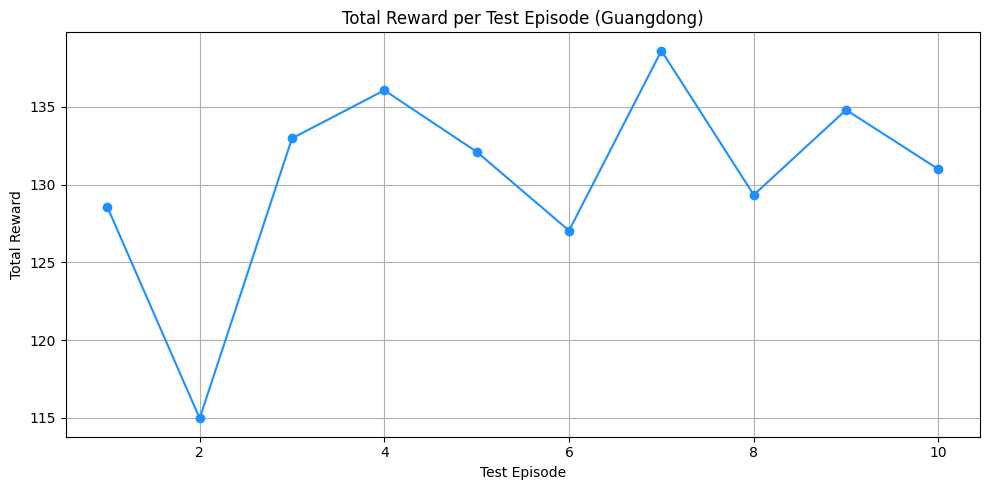

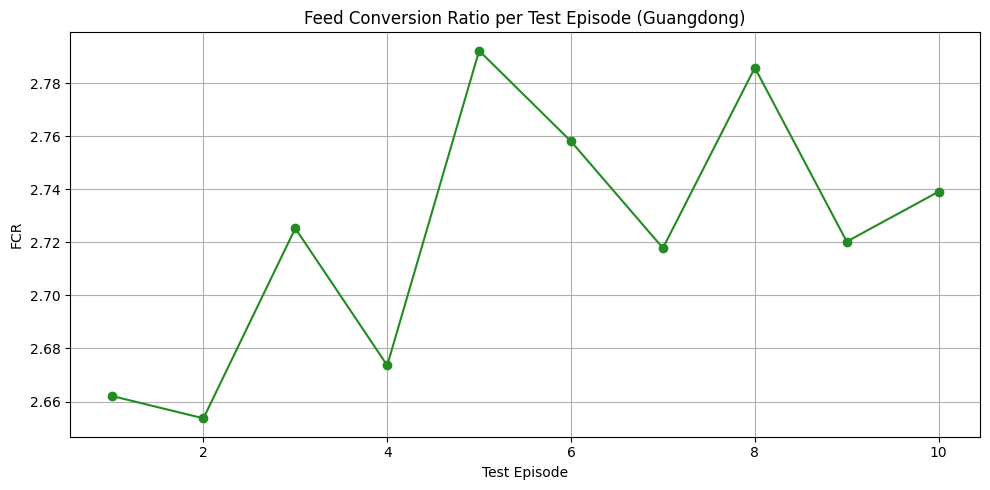

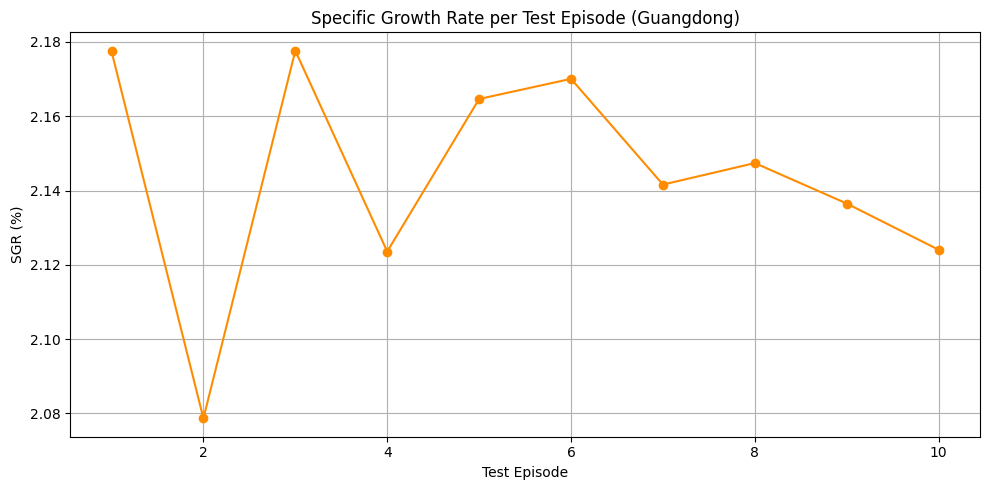

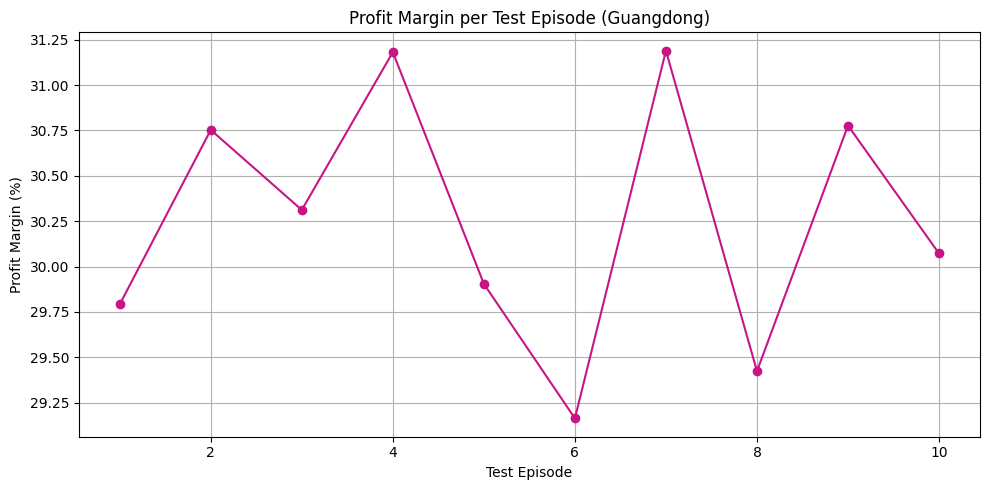

In [5]:
# Test in Guangdong
import pickle
import numpy as np
import matplotlib.pyplot as plt
from utils.calculation import Calculation
from envs.aquaculture_env import AquacultureEnv
from agent.dyna_q import DiscretizedDynaQAgent
from collections import defaultdict

# === Load Environment and Agent ===
env = AquacultureEnv(region="guangdong")
agent = DiscretizedDynaQAgent(
    env,
    alpha=0.0809,
    gamma=0.8954,
    planning_steps=6,
    replay_freq=5,
    obs_bins=15,
    exploration_final_eps=0.001
)

with open("saved_models/dynaq_north_sulawesi.pkl", "rb") as f:
    q_table = pickle.load(f)
    agent.q_table = defaultdict(lambda: np.zeros(len(agent.action_space)), q_table)

# === Aggregation lists ===
reward_list = []
fcr_list = []
sgr_list = []
profit_margin_list = []

for run in range(10):
    obs, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    total_feed_grams = 0
    fish_values = []
    total_costs = []

    state = agent.discretize_obs(obs)
    initial_biomass = env._compute_total_biomass()

    while not (terminated or truncated):
        action_idx = np.argmax(agent.q_table[state])
        action = np.array(agent.action_space[action_idx], dtype=np.float32)

        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        total_feed_grams += env.feed_today
        fish_values.append(info["fish_value"])
        total_costs.append(info["feed_cost"] + info["heat_cost"] + info["oxygenation_cost"])
        state = agent.discretize_obs(obs)

    final_biomass = env._compute_total_biomass()
    fcr = Calculation.compute_fcr(total_feed_grams / 1000, final_biomass / 1000, initial_biomass / 1000)
    sgr = Calculation.compute_sgr(initial_biomass / 1000, final_biomass / 1000)
    pmargin = Calculation.compute_profit_margin(fish_values, total_costs)

    reward_list.append(total_reward)
    if fcr is not None:
        fcr_list.append(fcr)
    if sgr is not None:
        sgr_list.append(sgr)
    if pmargin is not None:
        profit_margin_list.append(pmargin)

# === Print Averages ===
print(f"\n🧪 Evaluation Results over 10 Test Episodes ({env.region}):")
print(f"Average Total Reward:             {np.mean(reward_list):.2f}")
print(f"Average Feed Conversion Ratio:   {np.mean(fcr_list):.2f}")
print(f"Average Specific Growth Rate:    {np.mean(sgr_list):.2f}%")
print(f"Average Profit Margin:           {np.mean(profit_margin_list):.2f}%")

# === Plot Function with Line Graphs ===
def plot_line(values, ylabel, title, color='blue'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(values) + 1), values, marker='o', linestyle='-', color=color)
    plt.title(f"{title} ({env.region.title()})")
    plt.xlabel("Test Episode")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Plot All ===
plot_line(reward_list, "Total Reward", "Total Reward per Test Episode", color='dodgerblue')
plot_line(fcr_list, "FCR", "Feed Conversion Ratio per Test Episode", color='forestgreen')
plot_line(sgr_list, "SGR (%)", "Specific Growth Rate per Test Episode", color='darkorange')
plot_line(profit_margin_list, "Profit Margin (%)", "Profit Margin per Test Episode", color='mediumvioletred')


### Test on Different Environment with optimized hyperparameter
## Region: Kafr El-Shaikh  (Easy Scenario)
Using the best hyperparameters optimized via Optuna:

Learning Rate (α): 0.0809

Discount Factor (γ): 0.8954

Planning Steps: 6

Observation Bins: 15

Replay_freq: 5

Epsilon (ε): 0.001 (low exploration)

The model was tested on the Kafr El-Shaikh  region, which is considered a more challenging environment due to its fluctuating temperature and water quality. This test helps assess the generalization ability and robustness of the learned policy when transferred to a different and more complex setting.






🧪 Evaluation Results over 10 Test Episodes (kafr_el_sheikh):
Average Total Reward:             189.01
Average Feed Conversion Ratio:   2.96
Average Specific Growth Rate:    2.08%
Average Profit Margin:           53.43%


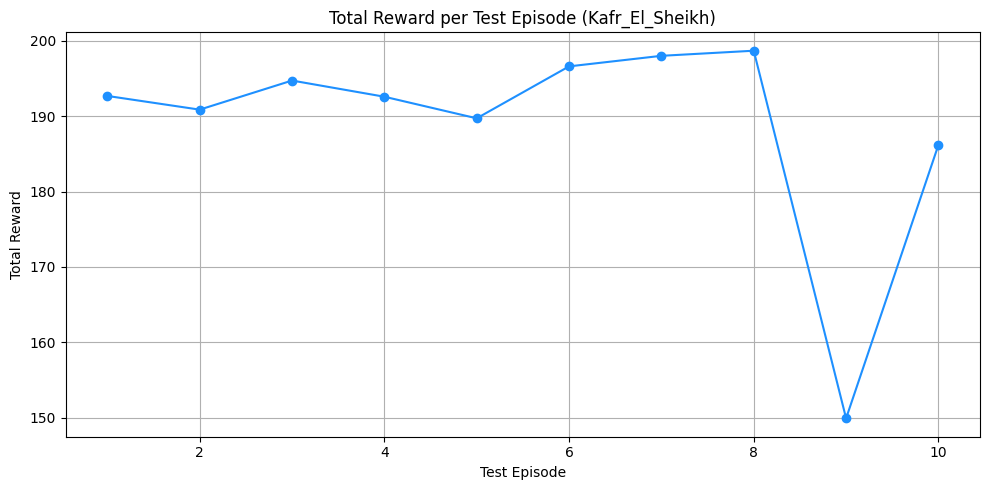

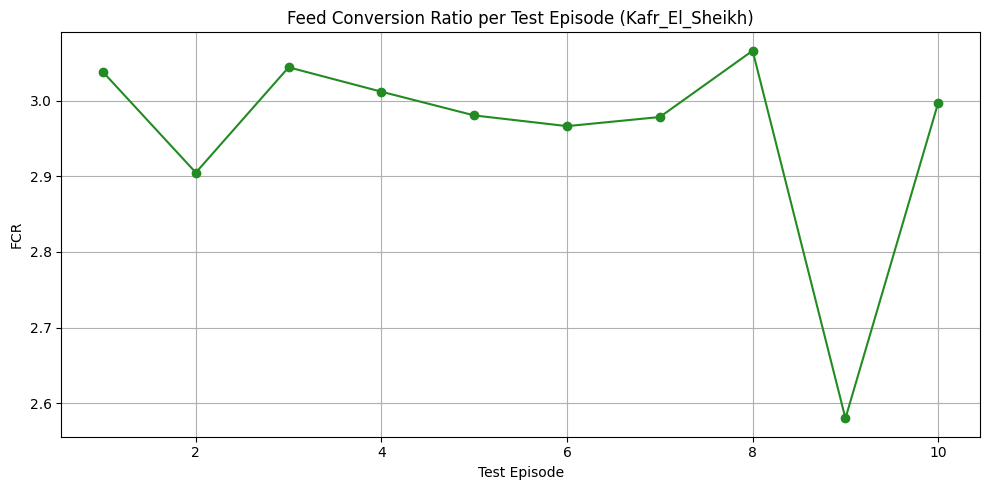

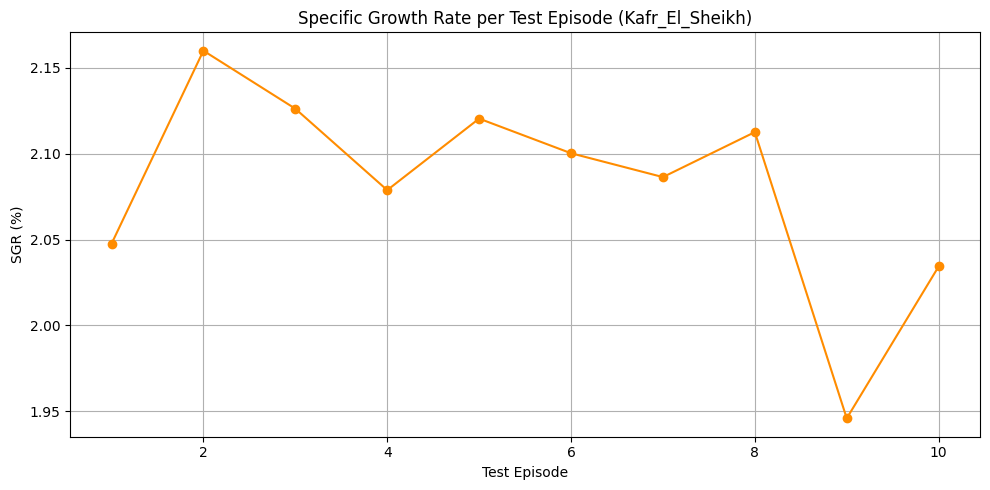

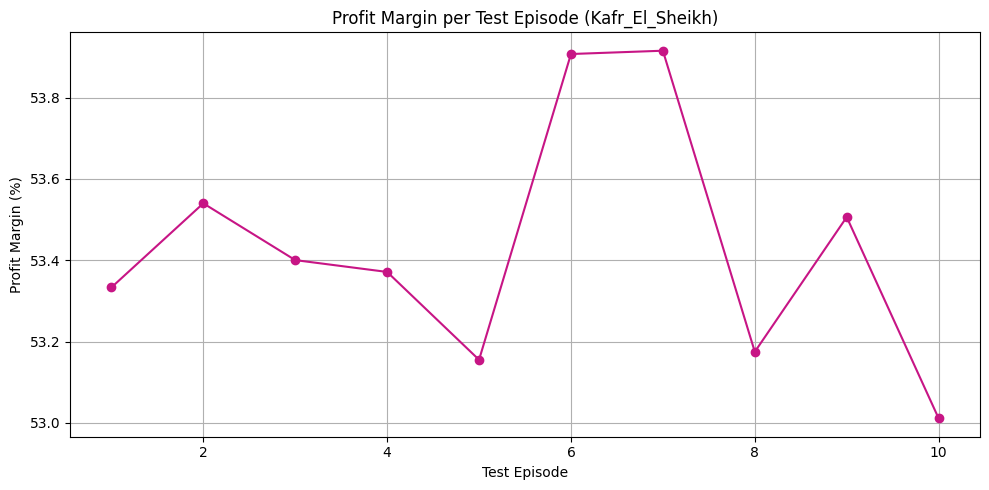

In [6]:
# Test in Kafr El-Shaikh
import pickle
import numpy as np
import matplotlib.pyplot as plt
from utils.calculation import Calculation
from envs.aquaculture_env import AquacultureEnv
from agent.dyna_q import DiscretizedDynaQAgent
from collections import defaultdict

# === Load Environment and Agent ===
env = AquacultureEnv(region="kafr_el_sheikh")
agent = DiscretizedDynaQAgent(
    env,
    alpha=0.0809,
    gamma=0.8954,
    planning_steps=6,
    replay_freq=5,
    obs_bins=15,
    exploration_final_eps=0.001
)

with open("saved_models/dynaq_north_sulawesi.pkl", "rb") as f:
    q_table = pickle.load(f)
    agent.q_table = defaultdict(lambda: np.zeros(len(agent.action_space)), q_table)

# === Aggregation lists ===
reward_list = []
fcr_list = []
sgr_list = []
profit_margin_list = []

for run in range(10):
    obs, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    total_feed_grams = 0
    fish_values = []
    total_costs = []

    state = agent.discretize_obs(obs)
    initial_biomass = env._compute_total_biomass()

    while not (terminated or truncated):
        action_idx = np.argmax(agent.q_table[state])
        action = np.array(agent.action_space[action_idx], dtype=np.float32)

        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        total_feed_grams += env.feed_today
        fish_values.append(info["fish_value"])
        total_costs.append(info["feed_cost"] + info["heat_cost"] + info["oxygenation_cost"])
        state = agent.discretize_obs(obs)

    final_biomass = env._compute_total_biomass()
    fcr = Calculation.compute_fcr(total_feed_grams / 1000, final_biomass / 1000, initial_biomass / 1000)
    sgr = Calculation.compute_sgr(initial_biomass / 1000, final_biomass / 1000)
    pmargin = Calculation.compute_profit_margin(fish_values, total_costs)

    reward_list.append(total_reward)
    if fcr is not None:
        fcr_list.append(fcr)
    if sgr is not None:
        sgr_list.append(sgr)
    if pmargin is not None:
        profit_margin_list.append(pmargin)

# === Print Averages ===
print(f"\n🧪 Evaluation Results over 10 Test Episodes ({env.region}):")
print(f"Average Total Reward:             {np.mean(reward_list):.2f}")
print(f"Average Feed Conversion Ratio:   {np.mean(fcr_list):.2f}")
print(f"Average Specific Growth Rate:    {np.mean(sgr_list):.2f}%")
print(f"Average Profit Margin:           {np.mean(profit_margin_list):.2f}%")

# === Plot Function with Line Graphs ===
def plot_line(values, ylabel, title, color='blue'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(values) + 1), values, marker='o', linestyle='-', color=color)
    plt.title(f"{title} ({env.region.title()})")
    plt.xlabel("Test Episode")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Plot All ===
plot_line(reward_list, "Total Reward", "Total Reward per Test Episode", color='dodgerblue')
plot_line(fcr_list, "FCR", "Feed Conversion Ratio per Test Episode", color='forestgreen')
plot_line(sgr_list, "SGR (%)", "Specific Growth Rate per Test Episode", color='darkorange')
plot_line(profit_margin_list, "Profit Margin (%)", "Profit Margin per Test Episode", color='mediumvioletred')
